# 모델2
- 기사제목+댓글내용 텍스트가 어떤 후보인지 판단하는 모델
- '영화 리뷰가 긍정/부정인지 예측'하는 파일 참고
- '다중분류' 참고


- Feature
    - 텍스트
- Label
    - 후보자
        - 박영선 1
        - 오세훈 2
        - 김영춘 3
        - 박형준 4

In [1]:
# 기본 라이브러리
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('seaborn-whitegrid')
import missingno
import re
import os
# 데이터
from sklearn.datasets import load_iris

# 경고메시지 제거
import warnings 
warnings.filterwarnings('ignore')

# KFold
from sklearn.model_selection import KFold # 순서대로 하거나 or 랜덤하게 클래스를 나눈다.
from sklearn.model_selection import StratifiedKFold # 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# 학습데이터와 검증데이터로 나누는 함수
from sklearn.model_selection import train_test_split

# 데이터 전처리
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
    
# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# 추가항목
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 비지도학습 - 군집
from sklearn.cluster import KMeans
from sklearn.cluster import mean_shift

# 딥러닝
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

# CNN
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

# NLP
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
    # 문장을 단어 단위로 나누기
from keras.preprocessing.text import text_to_word_sequence
from keras.layers import Embedding

# 다중분류를 위한 원-핫 인코더
from keras.utils import to_categorical

# 더이상 성능 향상이 이루어지지 않는다면 조기 중단시킬 수 있는 함수
from keras.callbacks import EarlyStopping

# epoch마다 모델을 저장하는 함수
from keras.callbacks import ModelCheckpoint

# 파일로 저장된 딥러닝 모델을 객체로 복구하는 함수
from keras.models import load_model

# 저장
import pickle

# 시간 모듈
import time # 현재 시간값을 구할 수 있다.

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 13
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# GPU 메모리 사용량을 필요한 만큼만 증가하도록 설정

# 사용가능한 GPU 목록 가져오기
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # 필요한 만큼만 메모리를 사용할 수 있도록 설정하기
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# RandomSeed
np.random.seed(1)

In [4]:
df = pd.read_csv('data/취합_0407.csv')
df.head()

,제목,날짜,작성일,댓글,출처,"지역(서울:1, 부산:2)","정당(1:더불어민주당,2:국민의힘)","정당평가(부정;0, 긍정:1)",후보(기호 순),"후보평가(부정;0, 긍정:1)",제목댓글
0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-12 19:13:00,철수야! 뜸 들이지 말고 애국하는 마음으로 물러서라~~~,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이..."
1,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-09 13:49:00,박영선은 정동영이 얻은 36프로선에 머무를것. 4.7.이후 OOO정권은 몰락의 길 ...,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이..."
2,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:42:00,빵선이가서울시장되면서울은공산국가수도제2의평양이될것이다,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되..."
3,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:38:00,서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국.영국에 영주권자이므로...,조선일보,1.0,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당..."
4,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:02:00,부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은...,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이..."


In [5]:
# 데이터 구조
df.shape

(85679, 11)

In [6]:
# 제목, 날짜 컬럼 삭제
df = df.drop( columns=['제목','날짜','댓글'])

# 컬럼 이름 영어로 변경
cols = ['date','press','area', 'party','party_eval', 
        'candidate','candidate_eval','title_comment']
df.columns = cols
df.head(2)

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment
0,2021-03-12 19:13:00,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이..."
1,2021-03-09 13:49:00,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이..."


In [7]:
# 컬럼 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85679 entries, 0 to 85678
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            85679 non-null  object 
 1   press           85679 non-null  object 
 2   area            3286 non-null   float64
 3   party           1874 non-null   float64
 4   party_eval      1640 non-null   float64
 5   candidate       2172 non-null   float64
 6   candidate_eval  2053 non-null   float64
 7   title_comment   85679 non-null  object 
dtypes: float64(5), object(3)
memory usage: 5.2+ MB


## 1. 지역 컬럼 확인

In [8]:
df['area'].value_counts() 

1.0    2527
2.0     759
Name: area, dtype: int64

### (1) 후보번호 0.0 처리

In [9]:
df.pivot_table( index=['area', 'candidate'], aggfunc='count')

candidate_eval  date  party  party_eval  press  title_comment
area candidate                                                               
1.0  0.0                     1     1      0           0      1              1
     1.0                  1047  1162    214         166   1162           1162
     2.0                   824   828    126          47    828            828
     7.0                     2     2      0           0      2              2
2.0  1.0                    23    23     14           5     23             23
     2.0                   126   126     99           3    126            126

In [10]:
# 박영선(1) 부정 댓글. 따라서 후보자를 1.0으로 변경
df.query( 'area == 1.0 & candidate == 0.0')['title_comment'][70815]

'[100분토론LIVE] - (910회) 2021 서울시장, 당신의 선택은? - 4·7 보궐선거 서울시장 후보자 토론회박영선 존나 웃긴게지가 공격성 질문함 그래서 오세훈 대답하려 하면대답 못하게 하고 제 얘기를 들으세요 이러는거 무한반복 ㅋㅋㅋㅋㅋ'

In [11]:
df['candidate'][70815] = 1.0
df['candidate_eval'][70815] = 0.0

In [12]:
df.query( 'area == 1.0 & candidate == 0.0')

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment


### (2) 후보번호 7.0 처리

In [13]:
df.pivot_table( index=['area', 'candidate'], aggfunc='count')

candidate_eval  date  party  party_eval  press  title_comment
area candidate                                                               
1.0  1.0                  1048  1163    214         166   1163           1163
     2.0                   824   828    126          47    828            828
     7.0                     2     2      0           0      2              2
2.0  1.0                    23    23     14           5     23             23
     2.0                   126   126     99           3    126            126

In [14]:
# 후보번호 7.0 두개 존재
df.query( 'area == 1.0 & candidate == 7.0')

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment
70990,2021-03-28,유튜브,1.0,NaN,NaN,7.0,1.0,D-7 마지막 여론조사…박영선 32% vs 오세훈 55.8% / SBS / 주영진의...
70992,2021-03-29,유튜브,1.0,NaN,NaN,7.0,1.0,D-7 마지막 여론조사…박영선 32% vs 오세훈 55.8% / SBS / 주영진의...


In [15]:
# 텍스트 내용 '허경영' 관련된 내용 -> 제거 
df.query( 'area == 1.0 & candidate == 7.0')['title_comment'][70990]

'D-7 마지막 여론조사…박영선 32% vs 오세훈 55.8% / SBS / 주영진의 뉴스브리핑여론조사  ㅎㅎㅎㅎㅎ  오세훈 55  박영선 32  거짓말 그만해라 . 거짓으로 포장된 정치판 보기싫다 이민 가야겠다    허경영 33정책 마음에든다  애민정책'

In [16]:
# 텍스트 내용 '허경영' 관련된 내용 -> 제거 
df.query( 'area == 1.0 & candidate == 7.0')['title_comment'][70992]

'D-7 마지막 여론조사…박영선 32% vs 오세훈 55.8% / SBS / 주영진의 뉴스브리핑서울시민들깨어나십시요.여론조사엉터리허경영후보님도보여줘라!공평하게해라!40대들오세훈도박영선도아니허경영씨뿐이다거짓말하지마세요.'

In [17]:
# 후보번호 7.0번 삭제
df.drop( labels=df.query( 'area == 1.0 & candidate == 7.0').index, inplace=True )
# 인덱스 재배열
df.reset_index( drop=True, inplace=True )
df.shape

(85677, 8)

In [18]:
df.pivot_table( index=['area', 'candidate'], aggfunc='count')

candidate_eval  date  party  party_eval  press  title_comment
area candidate                                                               
1.0  1.0                  1048  1163    214         166   1163           1163
     2.0                   824   828    126          47    828            828
2.0  1.0                    23    23     14           5     23             23
     2.0                   126   126     99           3    126            126

## 2. 후보자 컬럼 추가
- 박영선 
- 오세훈 
- 김영춘 
- 박형준 

In [19]:
# 박영선 후보
ys_idx = df.query( 'area == 1.0 & candidate == 1.0').index

# 오세훈 후보
sh_idx = df.query( 'area == 1.0 & candidate == 2.0').index

# 김영춘 후보
yc_idx = df.query( 'area == 2.0 & candidate == 1.0').index

# 박형준 후보
hj_idx = df.query( 'area == 2.0 & candidate == 2.0').index

In [20]:
# 지역번호+후보번호 통합한 컬럼 형성
df['area_candidate'] = np.nan
df.head()

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment,area_candidate
0,2021-03-12 19:13:00,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이...",NaN
1,2021-03-09 13:49:00,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이...",NaN
2,2021-03-07 14:42:00,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되...",NaN
3,2021-03-07 14:38:00,조선일보,1.0,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당...",NaN
4,2021-03-07 14:02:00,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이...",NaN


In [21]:
# 후보별 지역+후보번호 컬럼 채우기

# 박영선 후보
df['area_candidate'][ys_idx] = '박영선'

# 오세훈 후보
df['area_candidate'][sh_idx] = '오세훈'

# 김영춘 후보
df['area_candidate'][yc_idx] = '김영춘'

# 박형준 후보
df['area_candidate'][hj_idx] = '박형준'

In [22]:
# 넷 후보가 아닌 경우 '기타'로 채우기

# 일단 후보자가 특정 안 된 500개 데이터를 '기타'로 채워서 학습시키기
null_idx = df[df['candidate'].isnull()].index
random_null_idx = np.random.choice( null_idx, size=500)
# random_null_idx

# 기타
df['area_candidate'][random_null_idx] = '기타'

In [23]:
# 후보자를 특정할 수 있는 데이터 개수( + '기타')
df['area_candidate'].notnull().sum()

2636

In [24]:
# 학습시킬 데이터의 클래스 종류
df['area_candidate'].value_counts()

박영선    1163
오세훈     828
기타      496
박형준     126
김영춘      23
Name: area_candidate, dtype: int64

# 다중분류
- **활성화 함수**를 **이용**하려면 Y값이 **0-1로 이루어져** 있어야 함
    - 원-핫 인코딩(One-Hot Encoding)

## X값 텍스트 지정
- 정규표현식으로 한글 외 데이터 제거

In [25]:
# 정규식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [26]:
df['title_comment'] = df['title_comment'].apply( lambda x: text_cleaning(x))

In [27]:
# 후보자 특정이 가능한 데이터의 인덱스 
notnull_idx = df[ df['area_candidate'].notnull() ].index

docs = list(df['title_comment'][notnull_idx].values)
len(docs)

2636

## y값 클래스 지정 
- 박영선 1, 오세훈 2, 김영춘 3, 박형준 4

In [28]:
# 문자열 인코딩
encoder = LabelEncoder()
y = encoder.fit_transform(df['area_candidate'][notnull_idx].values)
y

array([2, 2, 2, ..., 0, 0, 0])

In [29]:
print(encoder.classes_)
print('-'*30)
print( encoder.inverse_transform([0]) )
print( encoder.inverse_transform([1]) )
print( encoder.inverse_transform([2]) )
print( encoder.inverse_transform([3]) )
print( encoder.inverse_transform([4]) )

['기타' '김영춘' '박영선' '박형준' '오세훈']
------------------------------
['기타']
['김영춘']
['박영선']
['박형준']
['오세훈']


## y값 클래스 원-핫 인코딩

In [30]:
y_encoded = to_categorical(y)
y_encoded.shape 

(2636, 5)

In [31]:
y_encoded # 출력층 노드의 개수는 5으로 맞춰주기

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## 토큰화(Tokenizer)
- 텍스트를 잘게 나누는 것
- 단어별, 문장별, 형태소별, ...
- 이렇게 나누어진 하나의 단위를 **Token(토큰)**

In [32]:
token = Tokenizer() # 토큰화 함수 지정
token.fit_on_texts(docs) # 토큰화 함수에 문장 적용
print(token.word_index) # 각 단어에 매겨진 인덱스값 출력

{'박영선': 1, '서울시장': 2, '오세훈': 3, '보궐선거': 4, '주영진의': 5, '토론': 6, '후보': 7, '내곡동': 8, '후보자': 9, '땅': 10, '안철수': 11, '원인첫': 12, '어땠나': 13, '당신의': 14, '선택은': 15, '분토론': 16, '회': 17, '서울': 18, '박형준': 19, '더불어민주당': 20, '부산시장': 21, '이': 22, '민주당': 23, '토론회': 24, '마지막': 25, '왜': 26, '여론조사박영선': 27, '등': 28, '다시보기': 29, '이수봉': 30, '선거': 31, '그': 32, '나경원': 33, '야당': 34, '부산': 35, '고민정': 36, '분노': 37, '다': 38, '출마': 39, '오세훈이': 40, '또': 41, '쫓아내야': 42, '인방': 43, '사과에': 44, '더': 45, '박영선은': 46, '것': 47, '도대체': 48, '월': 49, '한다': 50, '시장': 51, '하는': 52, '선출': 53, '문재인': 54, '어떤': 55, '일이': 56, '년만에': 57, '재도전': 58, '수': 59, '김영춘': 60, '무슨': 61, '참': 62, '화이팅': 63, '가덕도': 64, '한방에': 65, '부동산': 66, '휘청': 67, '측': 68, '있는': 69, '번': 70, '뉴스브리핑박영선': 71, '년': 72, '단일화': 73, '이런': 74, '없는': 75, '새로운': 76, '합니다': 77, '편의점': 78, '정말': 79, '없다': 80, '것을': 81, '의혹': 82, '일': 83, '선언': 84, '하고': 85, '잘': 86, '좀': 87, '박영선이': 88, '한': 89, '그리고': 90, '시민이': 91, '논란': 92, '할': 93, '리더십': 94, '전': 95, '오세훈의': 96, '

In [33]:
# 앞서 만든 토큰의 인덱스로만 채워진 새로운 배열 생성
X = token.texts_to_sequences(docs) 
print(X[0])     # 토큰의 인덱스로 채워진 배열
print(docs[0])  # 실제 토큰

[240, 35, 60, 19, 674, 675, 455, 46, 2938, 1437, 5569, 5570, 1986, 843, 5571, 1438, 5572, 2939, 5573]
재보궐  부산 김영춘  박형준 서울도 양자 대결 박영선은 정동영이 얻은 프로선에 머무를것 이후 정권은 몰락의 길 페달을 급속히 밟을것이다


### ※ 문장별 토큰 개수 파악

In [34]:
# 각 토큰으로 채워진 배열에서 최대 토큰수 찾기
max_len = 0
for i in X:
    if max_len <= len(i):
        max_len = len(i)
        
max_len

813

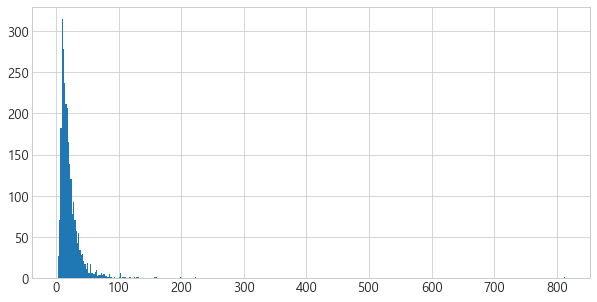

In [35]:
# 문장별 토큰 개수의 분포 확인
tmp = []
for i in X:
    tmp.append(len(i))

plt.hist( tmp, bins='auto' )
plt.show()

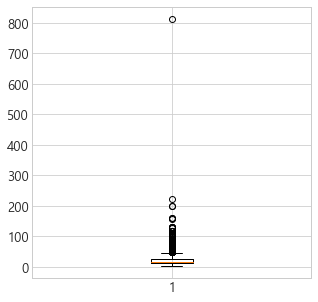

In [36]:
plt.figure(figsize=(5,5))
plt.boxplot(tmp) # 813개가 극단적인 것으로 볼 수 있음
plt.show() # 813개 토큰 제거

In [37]:
tmp.remove(813) # 극단치 제거

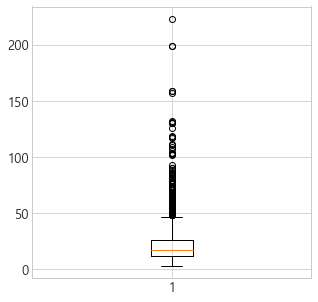

In [38]:
# 극단치 813문장 제거 후 문장별 토큰개수 파악
plt.figure(figsize=(5,5))
plt.boxplot(tmp) 
plt.show() 

In [39]:
# 토큰 개수의 분포 확인
pd.DataFrame(tmp, columns=['len(tokens)']).describe() 

,len(tokens)
count,2635.000000
mean,22.100949
std,17.333667
min,3.000000
25%,12.000000
50%,17.000000
75%,26.000000
max,223.000000


- 패딩(padding) 시 맞춰주는 배열의 길이는 토큰의 최대길이 199개로 맞춰준다.
- 임베딩(embedding) 시 배열을 압축할 때 사용하는 길이는 전체 문장의 75%가 포함되어 있는 25를 사용하여 압축한다.

## 패딩(Padding)
- 딥러닝 모델에 입력을 하려면 **학습 데이터의 길이가 동일해야함**
    - **길이를 맞춰주는 작업**
- 원하는 길이보다 짧은 부분은 숫자 0을 넣어 채우고,긴 데이터는 잘라서 같은 길이로 맞춘다.
- **한 문장의 토큰 개수 합이 가장 많은 것으로 채우는 것이 좋다.**


- 서로 다른 길이의 데이터를 **199**으로 맞춘다.

In [40]:
padded_x = pad_sequences(X, 199)
padded_x # 배열의 길이가 맞춰짐

array([[    0,     0,     0, ...,  5572,  2939,  5573],
       [    0,     0,     0, ...,   675,   455,  5574],
       [    0,     0,     0, ...,   455,  5575,  5576],
       ...,
       [    0,     0,     0, ..., 23023, 23024,   442],
       [    0,     0,     0, ...,    61, 23046,   375],
       [    0,     0,     0, ...,   708, 23048, 23049]])

## 임베딩(Embedding)
- **주어진 배열을 정해진 길이로 압축**
- 텍스트를 원-핫 인코딩 시 벡터의 길이가 너무 길어지는 문제 해결


- **Embedding**( 입력, 출력, 단어수 )
    - **입력**: 총 몇 개의 단어 집합
    - **출력**: 몇 개의 임베딩 결과 사용할 것인지(임의)
    - **단어수**: 매번 입력될 단어 수는 몇 개로 할 것인지

In [41]:
# 총 몇 개의 '인덱스'가 '입력' 되어야 하는지 정하기
word_size = len(token.word_index) + 1 # 전체 단어 맨 앞에 0이 먼저 나와야 함.
word_size

23050

## 단어 임베딩을 포함한 딥러닝 모델 생성 및 결과 출력

In [43]:
# 모델 설정
model = Sequential()
model.add(Embedding( word_size, 25 , input_length=199 ) )
model.add(Flatten())
model.add(Dense(5, activation='softmax')) # 다중분류

# 모델 컴파일
model.compile( loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
             )

# 모델 저장 조건 설정
model_path = 'model/model2/{epoch}-{val_loss}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', 
                               verbose=1,
                               save_best_only=True)
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=300)

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(padded_x, 
                                                     y_encoded, 
                                                     test_size=0.3, 
                                                     stratify=y_encoded)


# 모델 실행 및 저장
history = model.fit( X_train, y_train, validation_split=0.3, epochs=1500,
          callbacks=[early_stopping_callback, checkpointer])

Epoch 1/1500
41/41 [==============================] - 1s 9ms/step - loss: 1.3409 - accuracy: 0.4043 - val_loss: 1.2643 - val_accuracy: 0.4152

Epoch 00001: val_loss improved from inf to 1.26432, saving model to model/model2\1-1.264315128326416.hdf5
Epoch 2/1500
41/41 [==============================] - 0s 6ms/step - loss: 1.1872 - accuracy: 0.4624 - val_loss: 1.2233 - val_accuracy: 0.4152

Epoch 00002: val_loss improved from 1.26432 to 1.22326, saving model to model/model2\2-1.2232577800750732.hdf5
Epoch 3/1500
41/41 [==============================] - 0s 6ms/step - loss: 1.0322 - accuracy: 0.5973 - val_loss: 1.1268 - val_accuracy: 0.5072

Epoch 00003: val_loss improved from 1.22326 to 1.12678, saving model to model/model2\3-1.1267811059951782.hdf5
Epoch 4/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.7665 - accuracy: 0.8316 - val_loss: 0.9982 - val_accuracy: 0.5866

Epoch 00004: val_loss improved from 1.12678 to 0.99825, saving model to model/model2\4-0.99824506044

41/41 [==============================] - 0s 6ms/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.6485 - val_accuracy: 0.7419

Epoch 00035: val_loss did not improve from 0.64620
Epoch 36/1500
41/41 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.6492 - val_accuracy: 0.7383

Epoch 00036: val_loss did not improve from 0.64620
Epoch 37/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.6479 - val_accuracy: 0.7419

Epoch 00037: val_loss did not improve from 0.64620
Epoch 38/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.6480 - val_accuracy: 0.7419

Epoch 00038: val_loss did not improve from 0.64620
Epoch 39/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0042 - accuracy: 0.9994 - val_loss: 0.6501 - val_accuracy: 0.7383

Epoch 00039: val_loss did not improve from 0.64620
Epoch 40/1500
41/41 [==================

41/41 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 0.9964 - val_loss: 0.6598 - val_accuracy: 0.7329

Epoch 00119: val_loss did not improve from 0.64620
Epoch 120/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 0.9979 - val_loss: 0.6547 - val_accuracy: 0.7383

Epoch 00120: val_loss did not improve from 0.64620
Epoch 121/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0042 - accuracy: 0.9970 - val_loss: 0.6557 - val_accuracy: 0.7365

Epoch 00121: val_loss did not improve from 0.64620
Epoch 122/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.6579 - val_accuracy: 0.7365

Epoch 00122: val_loss did not improve from 0.64620
Epoch 123/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0027 - accuracy: 0.9987 - val_loss: 0.6591 - val_accuracy: 0.7365

Epoch 00123: val_loss did not improve from 0.64620
Epoch 124/1500
41/41 [=============


Epoch 00160: val_loss did not improve from 0.64620
Epoch 161/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 0.9961 - val_loss: 0.6708 - val_accuracy: 0.7329

Epoch 00161: val_loss did not improve from 0.64620
Epoch 162/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0049 - accuracy: 0.9960 - val_loss: 0.6776 - val_accuracy: 0.7401

Epoch 00162: val_loss did not improve from 0.64620
Epoch 163/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0023 - accuracy: 0.9986 - val_loss: 0.6771 - val_accuracy: 0.7329

Epoch 00163: val_loss did not improve from 0.64620
Epoch 164/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 0.9952 - val_loss: 0.6776 - val_accuracy: 0.7329

Epoch 00164: val_loss did not improve from 0.64620
Epoch 165/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.6753 - val_accuracy: 0.7365

Epoch 00165: val_lo


Epoch 00243: val_loss did not improve from 0.64620
Epoch 244/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.7183 - val_accuracy: 0.7256

Epoch 00244: val_loss did not improve from 0.64620
Epoch 245/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0032 - accuracy: 0.9984 - val_loss: 0.7307 - val_accuracy: 0.7238

Epoch 00245: val_loss did not improve from 0.64620
Epoch 246/1500
41/41 [==============================] - 0s 6ms/step - loss: 9.4183e-04 - accuracy: 0.9993 - val_loss: 0.7299 - val_accuracy: 0.7202

Epoch 00246: val_loss did not improve from 0.64620
Epoch 247/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 0.9978 - val_loss: 0.7170 - val_accuracy: 0.7148

Epoch 00247: val_loss did not improve from 0.64620
Epoch 248/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0045 - accuracy: 0.9946 - val_loss: 0.7297 - val_accuracy: 0.7220

Epoch 00248: va

41/41 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.9975 - val_loss: 0.7660 - val_accuracy: 0.7184

Epoch 00327: val_loss did not improve from 0.64620
Epoch 328/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 0.7663 - val_accuracy: 0.7184

Epoch 00328: val_loss did not improve from 0.64620
Epoch 329/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0030 - accuracy: 0.9970 - val_loss: 0.7655 - val_accuracy: 0.7202

Epoch 00329: val_loss did not improve from 0.64620
Epoch 330/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 0.9976 - val_loss: 0.7644 - val_accuracy: 0.7202

Epoch 00330: val_loss did not improve from 0.64620
Epoch 331/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.9983 - val_loss: 0.7661 - val_accuracy: 0.7184

Epoch 00331: val_loss did not improve from 0.64620


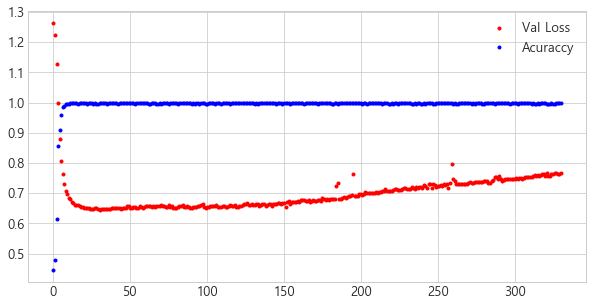

In [44]:
# 테스트셋으로 실험 결과의 오차값을 저장
y_vloss = history.history['val_loss']

# 학습셋으로 측정한 정확도의 값 저장
y_acc = history.history['accuracy']

# x값을 지정하고 그래프로 확인
x_len = np.arange(len(y_acc))
plt.plot( x_len, y_vloss, 'o', c='red', markersize=3, label='Val Loss')
plt.plot(x_len, y_acc, 'o', c='blue', markersize=3, label='Acuraccy')
plt.legend()
plt.show()

## 정확도

In [45]:
# 훈련 데이터 정확도
print(model.evaluate(X_train,y_train)[1])

# 테스트 데이터 정확도
print(model.evaluate(X_test, y_test)[1])

58/58 [==============================] - 0s 2ms/step - loss: 0.2316 - accuracy: 0.9144
0.9143631458282471
25/25 [==============================] - 0s 2ms/step - loss: 0.8186 - accuracy: 0.7358
0.7357774972915649


## 최적 모델 불러오기

In [ ]:
best_model = load_model('/model/model2/08-1.4119.hdf5')

## 학습하지 않은 데이터로 후보자 구별하기

In [46]:
null_idx = df[df['candidate'].isnull()].index
df2 = df.iloc[null_idx]

In [47]:
docs2 = list(df2['title_comment'].values)
token2 = Tokenizer()
token2.fit_on_texts(docs2)

In [48]:
# 앞서 만든 토큰의 인덱스로만 채워진 새로운 배열 생성
X2 = token.texts_to_sequences(docs2) 

In [49]:
print(X2[0])
print(docs2[0])

[240, 35, 60, 19, 674, 675, 455, 1476, 323, 4019, 14855]
재보궐  부산 김영춘  박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마음으로 물러서라


In [50]:
padded_x2 = pad_sequences(X2, 199)
padded_x2.shape

(83507, 199)

In [51]:
pred_y2 = np.argmax(model.predict(padded_x2), axis = 1)
pred_y2

array([4, 4, 4, ..., 2, 2, 4], dtype=int64)

In [52]:
# 결과 디코딩
y_pred = encoder.inverse_transform(pred_y2)
y_pred

array(['오세훈', '오세훈', '오세훈', ..., '박영선', '박영선', '오세훈'], dtype=object)

In [53]:
# 결과값 확인
pd.Series(y_pred).value_counts()

박영선    33419
기타     25354
오세훈    17946
박형준     3602
김영춘     3186
dtype: int64

## 예측한 후보 데이터와 기존 존재하는 후보 데이터 합치기
- 모델1을 위해

In [54]:
# 예측한 후보이름을 새로운 컬럼에 넣기
df2['pred_candidate'] = y_pred

In [55]:
# 'area_candidate' 컬럼의 nan값을 예측한 후보로 채우기
df2['area_candidate'] = df2['area_candidate'].fillna(df2['pred_candidate'])
# 'pred_candidate' 컬럼 제거
df2.drop( columns=['pred_candidate'], inplace=True)

In [56]:
# 기존에 후보이름이 있는(후보자 컬럼이 not null인) 데이터
df.iloc[notnull_idx]

# 합치기
df3 = pd.concat( [ df2, df.iloc[notnull_idx]] , axis=0)
df3.reset_index( drop=True, inplace=True )

In [57]:
df3.to_csv( 'data/취합_0407_1628_model2를 통한 후보자 예측 포함.csv', encoding='utf-8-sig')